In [105]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__
style.use('ggplot')

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader("TSLA", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-05,227.479996,221.949997,226.419998,226.750000,5911700,226.750000
2017-01-06,230.309998,225.449997,226.929993,229.009995,5527900,229.009995
2017-01-09,231.919998,228.000000,228.970001,231.279999,3957000,231.279999
2017-01-10,232.000000,226.889999,232.000000,229.869995,3660000,229.869995
2017-01-11,229.979996,226.679993,229.070007,229.729996,3650800,229.729996


In [106]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [107]:
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [109]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Ridge Regression
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Lasso Regression
clflasso = Lasso()
clflasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [110]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencelasso = clflasso.score(X_test,y_test)

In [111]:
print(confidencereg, confidencepoly2, confidencelasso)

0.9603963372966242 0.9652124819487747 0.9600791409235414


In [112]:
# Printing the forecast
def forecast_data(fitted_model):
    new_df = dfreg.copy()
    forecast_set = fitted_model.predict(X_lately)
    new_df['Forecast'] = np.nan

    last_date = dfreg.iloc[-1].name
    last_unix = last_date
    next_unix = last_unix + datetime.timedelta(days=1)

    for i in forecast_set:
        next_date = next_unix
        next_unix += datetime.timedelta(days=1)
        new_df.loc[next_date] = [np.nan for _ in range(len(new_df.columns)-1)]+[i]
    return new_df
    

In [113]:
def plot_prediction(fitted_model):
    # Adjusting the style of matplotlib
    new_df = forecast_data(fitted_model)
    new_df['Adj Close'].tail(500).plot()
    new_df['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

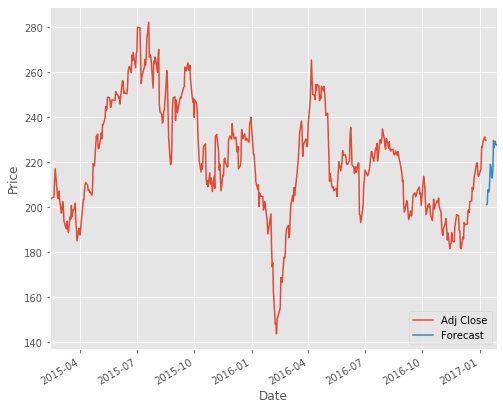

In [114]:
plot_prediction(clfreg)

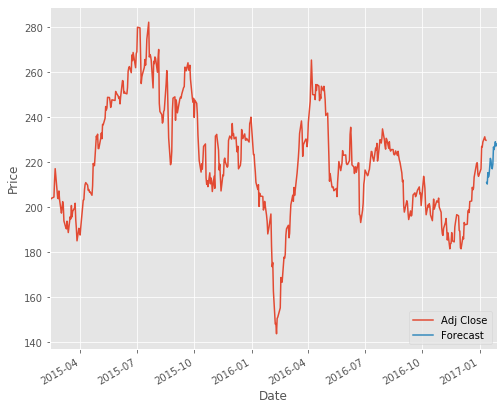

In [115]:
plot_prediction(clfpoly2)

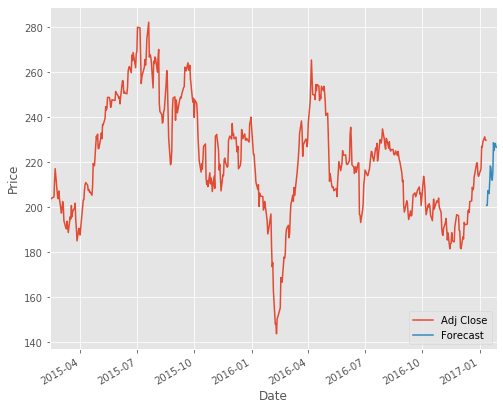

In [116]:
plot_prediction(clflasso)